<p style="text-align:right">
    项目名称：<b>人脸识别</b><br/>
设计：董相志<br/>
学号：220100<br/>
日期：2020.10<br/></p>

# 第三阶段：人脸相似度计算与比较
根据第二阶段完成的模型，完成人脸相似度计算，判断两个人脸是否为同一人。当然这个方案可能不准确，因为这取决于我们训练的教学演示模型的特征提取能力。所以如果采用第二阶段自定义模型，可先把注意力放在流程上。

### 工作步骤：
【1】定义模型结构，与第二阶段的模型相同，用于提取人脸特征。<br/>
【2】加载<b> 模型权重 </b><br/>
【3】计算两幅图像的相似度（余弦距离或欧氏距离）<br/>
【4】模型测试<br/>

#### 第二阶段模仿 VGG-16 自定义的CNN模型
<img src = './images/faceModel.JPG' />


实践中，我是把这个工作交给学生自己去完成的。毕竟是学生自己训练出来的模型，学生做起来也有积极性。

##### 课堂上，我采用了牛津大学计算机视觉组发布的VGGFace方案。VGGFace比DeepFace（2014）、FaceNet（2015）发布得稍晚一些，论文中也有比较。论文连接：
https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf

## 3.1 VGGface模型结构
<img src='./images/vgg-face-architecture.jpg' />
该模型也是16层，与ImageNet上训练的VGG-16的区别主要表现在输出层的维度是2622，后面的两个全连接采用了1x1的卷积实现。<br/>


<font color='red'>VGGFace这个模型有个很大的看点，即用一个普通的CNN，可以做到与大名鼎鼎的DeepFace、FaceNet一样的识别准确率</font>

<img src = "images/VGGFace_compare.PNG" width="300" height = "230" />

In [1]:
# 导入库
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Dense, \
     ZeroPadding2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

#### 论文中给出了VGGFace的详细结构定义如下：
<img src="images/VGGFace_structure.PNG" />

In [2]:
# 按照论文中参数设定，定义VGGFace模型
model = Sequential(name = 'VGGFace-Model')
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))  # 输入层
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
          
# 模型结构
model.summary()

Model: "VGGFace-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)   

上述模型结构写得比较细腻，将卷积块、池化层、Dropout层、填充层、激活函数层都做了区分。

## 3.2 加载模型权重

此处不需要重新训练模型，只需要去把第二阶段训练好的模型加载进来即可。此处用VGGFace预训练模型的权重替代。

In [3]:
# 加载模型预训练权重参数或者加载预训练模型
# 权重文件下载地址：
# https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view
model.load_weights('model/vgg_face_weights.h5')  # 权重文件请到咱们的教学群里下载

重新保存模型，将结构与权重一起保存。下一阶段直接用一个加载语句load_model即可重用模型。

In [4]:
model.save('model/vgg_face.h5')

提示的编译警告信息可以不用理会，因为后面我们只用这个预训练模型提取特征。

## 3.3 计算两幅图像的相似度

余弦与欧氏距离是常见的计算相似度方法。这里重点介绍余弦相似度

<font size = '4' color = 'red'><b>向量相似度定义：</b></font><br/><br/>
<img src='./images/cos.png' width="200" height="150" />
向量 <b>a</b> 与向量 <b>b</b> 间的余弦值可以通过欧几里得点积公式求出：<br/>
$$ a \cdot b = \Vert a \Vert \times \Vert b \Vert \times cos\theta $$ <br/>
给定两个属性向量 <b>A </b>和 <b>B </b>，其余弦相似性由点积和向量长度给出，如下所示：<br/>
$$ similarity = cos(\theta) = \frac{A \cdot B}{\Vert A \Vert \times \Vert B \Vert} = \frac{\displaystyle\sum_{i = 1}^{n}A_i \times B_i}{\sqrt[]{\displaystyle\sum_{i = 1}^{n}(A_i)^{2} }\sqrt[]{\displaystyle\sum_{i = 1}^{n}(B_i)^{2} } }$$ <br/>
上述公式中的$A_i、B_i$分别代表向量A和B的各分量。<br/><br/>
相似值取值范围：[-1,1]<br/>
-1：两个向量指向的方向正好截然相反<br/>
1：两个向量的指向是完全相同的<br/>
0：通常表示两个向量之间是独立的<br/>

In [5]:
# 图像预处理函数
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

这里给出了余弦距离和欧氏距离两种算法，可以让学生自由比较。

In [6]:
# 计算余弦距离
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - a / (np.sqrt(b) * np.sqrt(c))  # 用(1-余弦相似度)表示余弦距离

In [7]:
# 计算欧氏距离
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

不需要从头训练模型，此处也不做类似迁移学习的模型微调训练。
可以观看此处基于FaceNet的模型迁移学习训练。
链接：https://www.kaggle.com/upsunny/face-recognition-based-on-mtcnn-facenet-svm

In [8]:
# 定义特征提取模型，舍去最后一层(即Softmax激活函数层)
face_model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

关于如何设置距离阈值，有作者给出的余弦参考值是：0.40 ，欧氏距离是 120 。这是一个经验值，实战中可以根据场景做测试调整。

In [9]:
thresh = 0.4  #设定余弦距离阈值，低于这个值，认为是同一个人
# 距离计算函数，match_faces目录中存放了若干组比对照片
def verifyFace(img1, img2):
    #得到img1脸部特征值，这是一个长度为2622的特征向量
    img1_representation = face_model.predict( \
                        preprocess_image(f'./match_faces/{img1}'))[0,:]
    print(img1_representation)
    print(img1_representation.shape)
    #得到img2脸部特征值，这是一个长度为2622的特征向量
    img2_representation = face_model.predict( \
                        preprocess_image(f'./match_faces/{img2}'))[0,:]
    # 计算余弦相似度（距离）
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation) 
    # 绘图
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('./match_faces/{0}'.format(img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('./match_faces/{0}'.format(img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    print("余弦距离: ",cosine_similarity)
    # 显示比较结果
    if(cosine_similarity < thresh):
        print("是同一一个人！")
    else:
        print("不是同一个人!")

## 3.4 模型测试

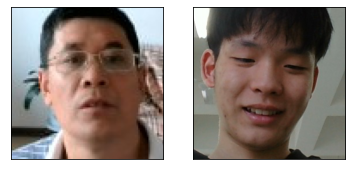

余弦距离:  0.4390917420387268
不是同一个人!


In [10]:
#不同的对象测试
verifyFace("dong.jpg", "two.jpg")

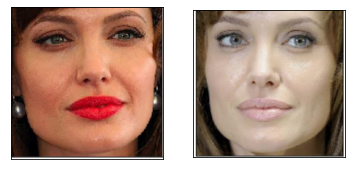

余弦距离:  0.2544904947280884
是同一一个人！


In [11]:
# 相同的对象测试
verifyFace("angelina.jpg", "angelina2.jpg")

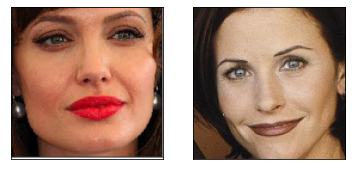

余弦距离:  0.4739535450935364
不是同一个人!


In [12]:
# 不同的对象测试
verifyFace("angelina.jpg", "Monica.jpg")

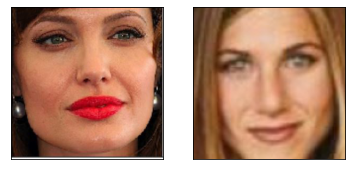

余弦距离:  0.7327100932598114
不是同一个人!


In [13]:
# 不同的对象测试
verifyFace("angelina.jpg", "Rachel.jpg")

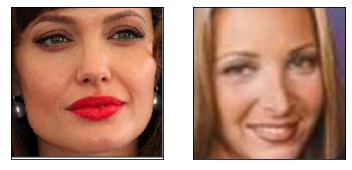

余弦距离:  0.6882018446922302
不是同一个人!


In [14]:
# 不同的对象测试
verifyFace("angelina.jpg", "Pheobe.jpg")

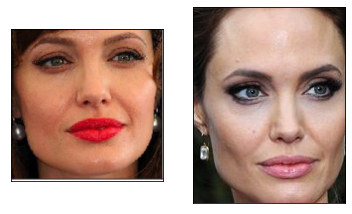

余弦距离:  0.38444697856903076
是同一一个人！


In [15]:
# 相同的对象测试
verifyFace("angelina.jpg", "angelina3.jpg")

### 这个模型有点儿准！！！！

<b>  本阶段的编程参照了Sefik Ilkin Serengil的博客 <br/>
博客网址: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
这个网址打开有些慢。

## 现在可以转入第四阶段了，实时人脸识别